In [15]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, matthews_corrcoef
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import Counter


## Завантаження та підготовка даних



In [16]:
# -------------------------------
# Завантаження та базова обробка
# -------------------------------
df = pd.read_csv("synthetic_coffee_health_10000.csv")
df = df.drop(columns=['ID'])

# -------------------------------
# Відокремлення цільової змінної
# -------------------------------
if 'Health_Issues' in df.columns:
    y = df['Health_Issues'].copy()
    df = df.drop(columns=['Health_Issues'])
else:
    y = None

## Інженерія ознак


In [17]:
# -------------------------------
# Інженерія ознак
# -------------------------------
df['Coffee_Sleep_Interaction'] = df['Coffee_Intake'] * df['Sleep_Hours']
df['Caffeine_per_Hour'] = df['Caffeine_mg'] / (df['Sleep_Hours'] + 1)
df['Age_Binned'] = pd.cut(df['Age'], bins=[18, 30, 50, 80],
                          labels=['Young', 'Middle', 'Old'])
df = df.drop(columns=['Age'])

# -------------------------------
# One-hot encoding (все текстове → числа)
# -------------------------------
cat_cols = ['Gender', 'Country', 'Sleep_Quality', 'Stress_Level',
            'Occupation', 'Smoking', 'Alcohol_Consumption', 'Age_Binned']
df = pd.get_dummies(df, columns=cat_cols)

# -------------------------------
# Масштабування числових ознак
# -------------------------------
scaler = StandardScaler()
num_cols = ['Coffee_Intake', 'Caffeine_mg', 'Sleep_Hours',
            'BMI', 'Heart_Rate', 'Physical_Activity_Hours',
            'Coffee_Sleep_Interaction', 'Caffeine_per_Hour']
df[num_cols] = scaler.fit_transform(df[num_cols])

# -------------------------------
# Заповнення пропусків
# -------------------------------
df = df.fillna(df.mean(numeric_only=True))
df = df.fillna(0)

# -------------------------------
# Навчання дерева, якщо є y
# -------------------------------
if y is not None and not y.isna().all():
    y = y.replace(['None', 'none', '', 'NaN', 'nan'], np.nan)
    mask = y.notna()
    df = df[mask]
    y = y[mask]
    
    le = LabelEncoder()
    y = le.fit_transform(y)
    print("✅ Класи після очищення:", le.classes_)
    print("✅ Кількість класів:", len(le.classes_))
        # Візуалізація розподілу цільової змінної
    X = df.copy()
    print("✅ X типи після підготовки:")
    print(X.dtypes.value_counts())  # переконайся, що все numeric

    dt_fs = DecisionTreeClassifier(criterion='gini', max_depth=8, random_state=42)
    dt_fs.fit(X, y)

    importances = pd.Series(dt_fs.feature_importances_, index=X.columns).sort_values(ascending=False)
    selected_features = importances.head(10).index

    print("\n✅ Топ-10 відібраних ознак за важливістю:")
    print(selected_features.tolist())

    X = X[selected_features]
else:
    print("⚙️ Пропускаємо навчання — 'Health_Issues' відсутній або порожній.")

print("\n✅ Data prepared successfully. Shape:", df.shape)

✅ Класи після очищення: ['Mild' 'Moderate' 'Severe']
✅ Кількість класів: 3
✅ X типи після підготовки:
bool       42
float64     8
Name: count, dtype: int64

✅ Топ-10 відібраних ознак за важливістю:
['Stress_Level_Low', 'BMI', 'Age_Binned_Old', 'Caffeine_per_Hour', 'Heart_Rate', 'Country_Australia', 'Country_Norway', 'Occupation_Healthcare', 'Country_USA', 'Sleep_Quality_Excellent']

✅ Data prepared successfully. Shape: (4059, 50)


## Розбиття на train / validation / test


In [18]:
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

X_train_np = X_train.values
X_val_np = X_val.values
X_test_np = X_test.values
y_train_np = y_train
y_val_np = y_val
y_test_np = y_test


## Власне дерево з  прунінгом


In [19]:

class MyDecisionTree:
    def __init__(self, max_depth=8, min_samples=2):
        self.max_depth = max_depth
        self.min_samples = min_samples
        self.tree = None

    def _most_common_label(self, y):
        """Допоміжний метод для пошуку найчастішого класу."""
        if len(y) == 0:
            return None
        return Counter(y).most_common(1)[0][0]

    def gini(self, y):
        """Розрахунок Gini impurity."""
        m = len(y)
        if m == 0:
            return 0
        # Оптимізований підрахунок ймовірностей
        counts = np.unique(y, return_counts=True)[1]
        probs = counts / m
        return 1 - np.sum(probs ** 2)

    def best_split(self, X, y):
        """Знаходження найкращого розбиття."""
        best_gini = float('inf')
        best_feature, best_threshold = None, None
        m, n_features = X.shape

        for feature_idx in range(n_features):
            # Перебираємо унікальні значення ознаки як порогові
            thresholds = np.unique(X[:, feature_idx])
            
            for t in thresholds:
                left_mask = X[:, feature_idx] <= t
                right_mask = ~left_mask
                
                # Якщо розбиття не ділить дані, пропускаємо
                if not np.any(left_mask) or not np.any(right_mask):
                    continue
                
                left_y = y[left_mask]
                right_y = y[right_mask]
                
                gini_left = self.gini(left_y)
                gini_right = self.gini(right_y)
                
                weighted_gini = (len(left_y) / m) * gini_left + (len(right_y) / m) * gini_right
                
                if weighted_gini < best_gini:
                    best_gini = weighted_gini
                    best_feature = feature_idx
                    best_threshold = t
                    
        return best_feature, best_threshold

    def build_tree(self, X, y, depth=0):
        """Рекурсивна побудова дерева."""
        most_common = self._most_common_label(y)
        
        # Критерії зупинки (Base cases)
        is_pure = len(np.unique(y)) == 1
        is_max_depth = depth >= self.max_depth
        is_min_samples = len(y) < self.min_samples

        if is_max_depth or is_pure or is_min_samples:
            return {'leaf': True, 'class': most_common}

        feature, threshold = self.best_split(X, y)

        # Якщо не вдалося знайти розділення (наприклад, всі ознаки однакові)
        if feature is None:
            return {'leaf': True, 'class': most_common}

        left_mask = X[:, feature] <= threshold
        right_mask = ~left_mask
        
        left_subtree = self.build_tree(X[left_mask], y[left_mask], depth + 1)
        right_subtree = self.build_tree(X[right_mask], y[right_mask], depth + 1)

        return {
            'leaf': False,
            'feature': feature,
            'threshold': threshold,
            'left': left_subtree,
            'right': right_subtree,
            'class': most_common  # Зберігаємо клас вузла для прунінгу
        }

    def fit(self, X, y):
        self.tree = self.build_tree(X, y)
        return self

    def predict_one(self, x, node=None):
        """Прогноз для одного зразка (рекурсивно)."""
        if node is None:
            node = self.tree
            
        if node['leaf']:
            return node['class']
            
        if x[node['feature']] <= node['threshold']:
            return self.predict_one(x, node['left'])
        else:
            return self.predict_one(x, node['right'])

    def predict(self, X):
        return np.array([self.predict_one(x) for x in X])

    def calculate_error(self, X, y, node):
        """Розрахунок помилки (частка неправильних відповідей)."""
        if len(X) == 0: return 0
        preds = np.array([self.predict_one(x, node) for x in X])
        return np.mean(preds != y)

    def count_leaves(self, node):
        if node['leaf']:
            return 1
        return self.count_leaves(node['left']) + self.count_leaves(node['right'])

    def prune_tree(self, node, alpha, validation_X, validation_y):
        """Cost-Complexity Pruning (post-order traversal)."""
        # Якщо це вже лист, повертаємо помилку цього листа
        if node['leaf']:
            return self.calculate_error(validation_X, validation_y, node)
        
        # Рекурсивний спуск
        left_error = self.prune_tree(node['left'], alpha, validation_X, validation_y)
        right_error = self.prune_tree(node['right'], alpha, validation_X, validation_y)
        
        subtree_error = left_error + right_error

        # Розрахунок помилки, якщо перетворити поточний вузол на лист
        temp_leaf_node = {'leaf': True, 'class': node['class']}
        leaf_error = self.calculate_error(validation_X, validation_y, temp_leaf_node)

        # Перевірка умови прунінгу:
        # Чи стала помилка (з урахуванням штрафу alpha) меншою або такою ж після обрізки?
        # У вагінальному коді: leaf_error <= subtree_error + alpha
        if leaf_error <= subtree_error + alpha:
            # Обрізаємо (перетворюємо на лист)
            node['leaf'] = True
            # Видаляємо зайві ключі для економії пам'яті
            node.pop('left', None)
            node.pop('right', None)
            node.pop('feature', None)
            node.pop('threshold', None)
            return leaf_error
            
        return subtree_error

## Навчання та оцінка моделей


In [20]:
# Власне дерево
tree = MyDecisionTree(max_depth=8, min_samples=5)
tree.fit(X_train_np, y_train_np)

y_pred_my = tree.predict(X_test_np)
print("=== Власне дерево (до прунінгу) ===")
print("Accuracy:", accuracy_score(y_test_np, y_pred_my))
print("F1-score:", f1_score(y_test_np, y_pred_my, average='weighted'))
print("MCC:", matthews_corrcoef(y_test_np, y_pred_my))

alpha = 0.001
tree.prune_tree(tree.tree, alpha, X_val_np, y_val_np)
y_pred_pruned = tree.predict(X_test_np)

print("\n=== Власне дерево (після прунінгу) ===")
print("Accuracy:", accuracy_score(y_test_np, y_pred_pruned))
print("F1-score:", f1_score(y_test_np, y_pred_pruned, average='weighted'))
print("MCC:", matthews_corrcoef(y_test_np, y_pred_pruned))


=== Власне дерево (до прунінгу) ===
Accuracy: 0.993431855500821
F1-score: 0.9933903644743393
MCC: 0.9683521126938622

=== Власне дерево (після прунінгу) ===
Accuracy: 0.8817733990147784
F1-score: 0.8263740231604467
MCC: 0.0


In [21]:
# sklearn DecisionTree
dt_sk = DecisionTreeClassifier(criterion='gini', max_depth=8, random_state=42)
dt_sk.fit(X_train_np, y_train_np)
y_pred_sk = dt_sk.predict(X_test_np)

print("\n=== sklearn DecisionTree ===")
print("Accuracy:", accuracy_score(y_test_np, y_pred_sk))
print("F1-score:", f1_score(y_test_np, y_pred_sk, average='weighted'))
print("MCC:", matthews_corrcoef(y_test_np, y_pred_sk))



=== sklearn DecisionTree ===
Accuracy: 0.9901477832512315
F1-score: 0.9900211764060752
MCC: 0.9522518777206742


In [22]:
# RandomForest 
rf = RandomForestClassifier(n_estimators=300, max_features='sqrt', random_state=42)
rf.fit(X_train_np, y_train_np)
y_pred_rf = rf.predict(X_test_np)

print("\n=== RandomForest ===")
print("Accuracy:", accuracy_score(y_test_np, y_pred_rf))
print("F1-score:", f1_score(y_test_np, y_pred_rf, average='weighted'))
print("MCC:", matthews_corrcoef(y_test_np, y_pred_rf))



=== RandomForest ===
Accuracy: 0.9917898193760263
F1-score: 0.9916568016554167
MCC: 0.960338470538921


## Confusion Matrix для всіх моделей


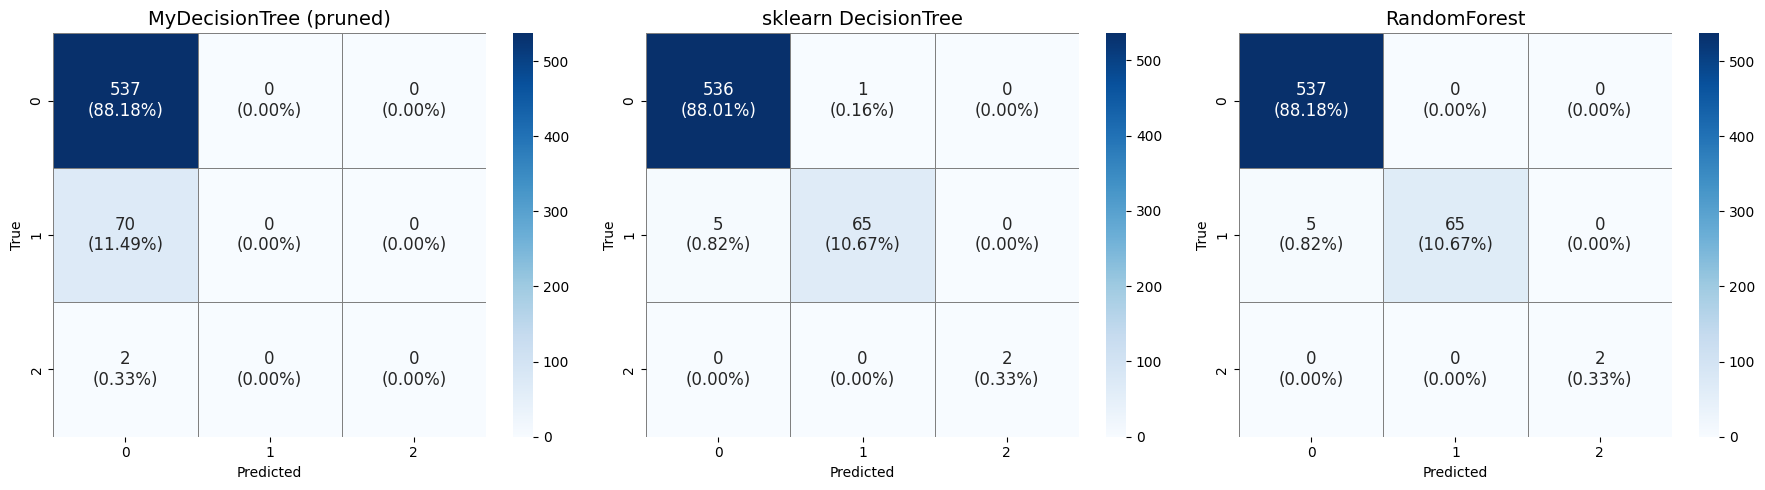

In [27]:
# Налаштування розміру одного графіку
plt.figure(figsize=(18, 5))

for i, (name, y_pred) in enumerate(models.items(), 1):
    plt.subplot(1, 3, i)
    cm = confusion_matrix(y_test_np, y_pred)
    
    # Логіка для тексту (число + відсоток)
    group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
    labels = [f"{v1}\n({v2})" for v1, v2 in zip(group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(cm.shape)

    sns.heatmap(cm, annot=labels, fmt='', cmap='Blues', 
                cbar=True, linewidths=0.5, linecolor='gray',
                annot_kws={"size": 12})
    
    plt.title(f"{name}", fontsize=14)
    plt.xlabel("Predicted")
    plt.ylabel("True")

plt.tight_layout()
plt.show()

## Важливість ознак (RandomForest)


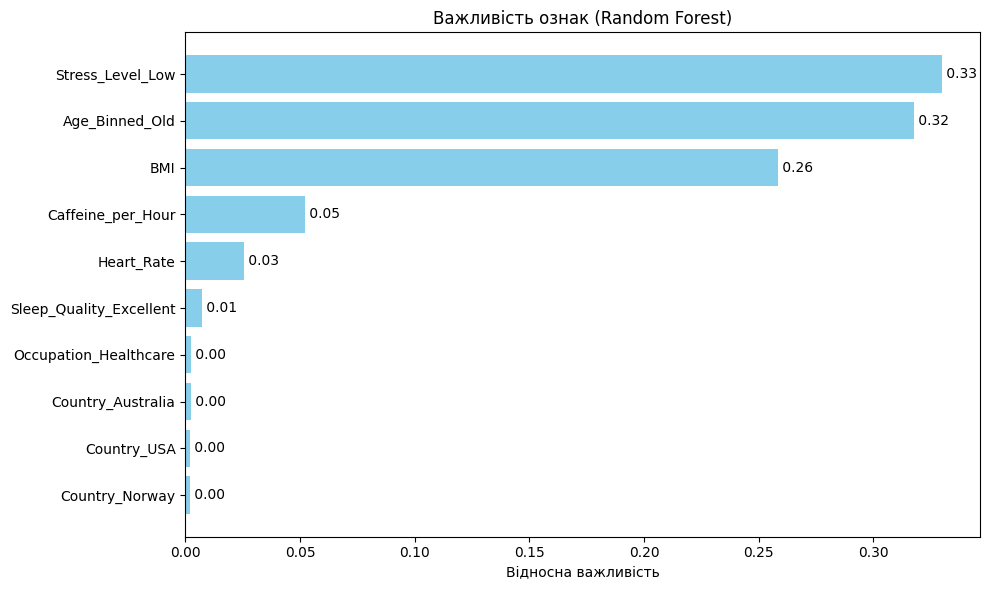

In [30]:
importances = rf.feature_importances_
indices = np.argsort(importances) # Сортуємо по зростанню для barh
# Отримання назв (безпечна перевірка)
f_names = X.columns if hasattr(X, 'columns') else np.array([f"Feature {i}" for i in range(X.shape[1])])
plt.figure(figsize=(10, 6))
plt.title("Важливість ознак (Random Forest)")

bars = plt.barh(range(len(indices)), importances[indices], color='skyblue', align='center')
plt.yticks(range(len(indices)), f_names[indices])
plt.xlabel("Відносна важливість")
# Додаємо цифри біля кожного стовпчика
for i, v in enumerate(importances[indices]):
    plt.text(v, i, f" {v:.2f}", va='center', fontsize=10, color='black')

plt.tight_layout()
plt.show()

## Розподіл цільової змінної (Health_Issues)


0    3579
1     463
2      17
Name: count, dtype: int64
   Count
0   3579
1    463
2     17


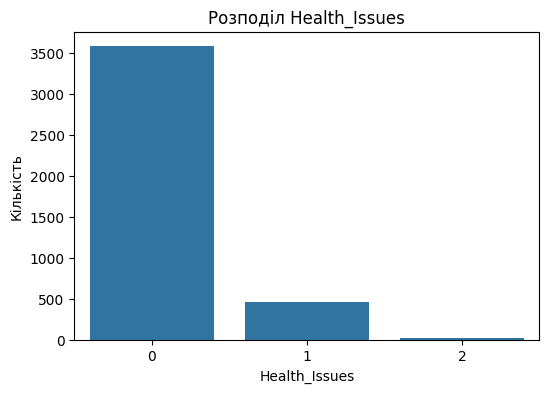

In [32]:
y_series = pd.Series(y)

# Підрахунок кількості кожної категорії
counts = y_series.value_counts()

# Виведення у консоль
print(counts)
print(counts.to_frame(name='Count'))

# Побудова графіка
plt.figure(figsize=(6, 4))
sns.countplot(x=y_series)
plt.title("Розподіл Health_Issues")
plt.xlabel("Health_Issues")
plt.ylabel("Кількість")
plt.show()



## ROC-криві для всіх моделей


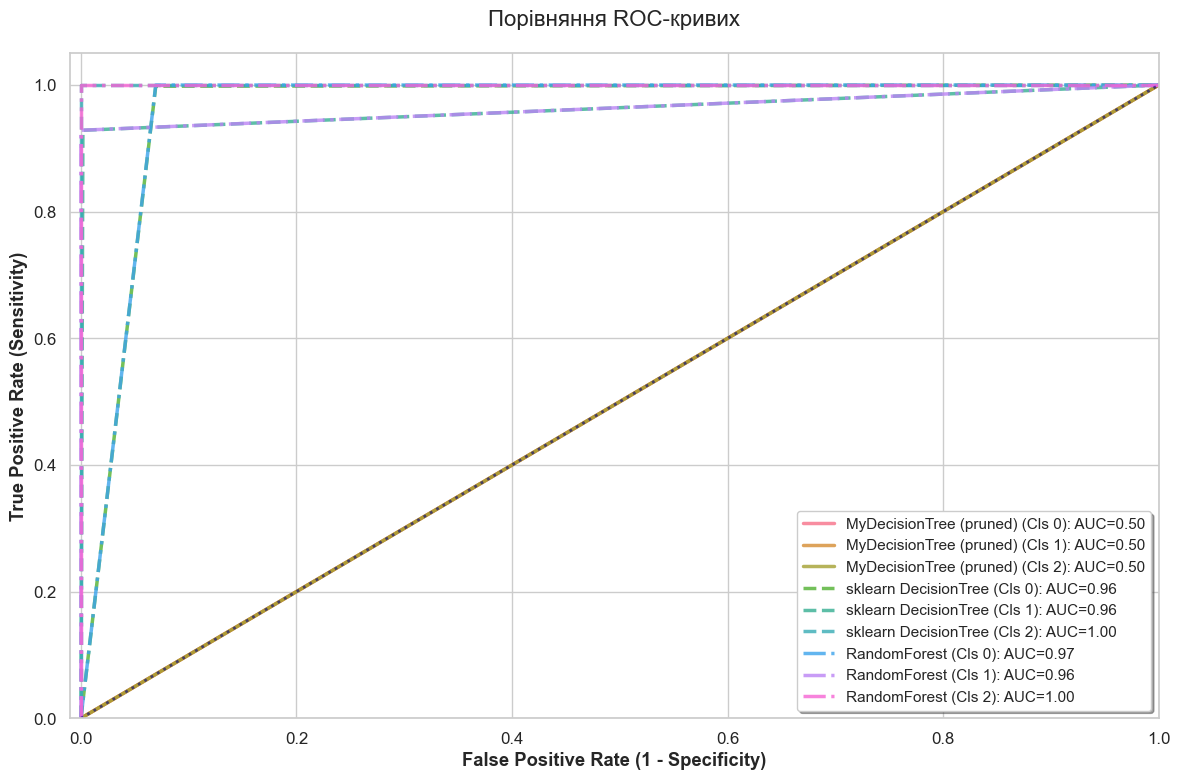

In [35]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np
import seaborn as sns

# Встановлюємо стиль Seaborn для красивих графіків
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.1)

# Бінаризація (без змін)
y_test_bin = label_binarize(y_test_np, classes=np.unique(y_test_np))
n_classes = y_test_bin.shape[1]

plt.figure(figsize=(12, 8))

# Визначаємо палітру кольорів (distinct colors)
colors = sns.color_palette("husl", n_colors=len(models) * n_classes)
color_idx = 0

# Стилі ліній для різних моделей, щоб їх розрізняти
line_styles = ['-', '--', '-.'] 
model_idx = 0

for name, y_pred in models.items():
    y_pred_bin = label_binarize(y_pred, classes=np.unique(y_test_np))
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    # Вибираємо стиль лінії для поточної моделі
    current_ls = line_styles[model_idx % len(line_styles)]
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_bin[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        
        plt.plot(fpr[i], tpr[i], 
                 color=colors[color_idx], 
                 linestyle=current_ls,
                 lw=2.5, 
                 alpha=0.8,
                 label=f'{name} (Cls {i}): AUC={roc_auc[i]:.2f}')
        color_idx += 1
    model_idx += 1

# Діагональна лінія (випадкове вгадування)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle=':', alpha=0.6)

plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate (1 - Specificity)", fontweight='bold')
plt.ylabel("True Positive Rate (Sensitivity)", fontweight='bold')
plt.title("Порівняння ROC-кривих", fontsize=16, pad=20)
plt.legend(loc="lower right", frameon=True, shadow=True, fontsize='small')

plt.tight_layout()
plt.show()


📉 Стандартне відхилення ДО обрізання:
BMI                         1.108152
Caffeine_per_Hour           1.108099
Coffee_Intake               1.014060
Caffeine_mg                 1.013931
Physical_Activity_Hours     1.002331
Heart_Rate                  0.995777
Sleep_Hours                 0.928526
Coffee_Sleep_Interaction    0.886763
dtype: float64


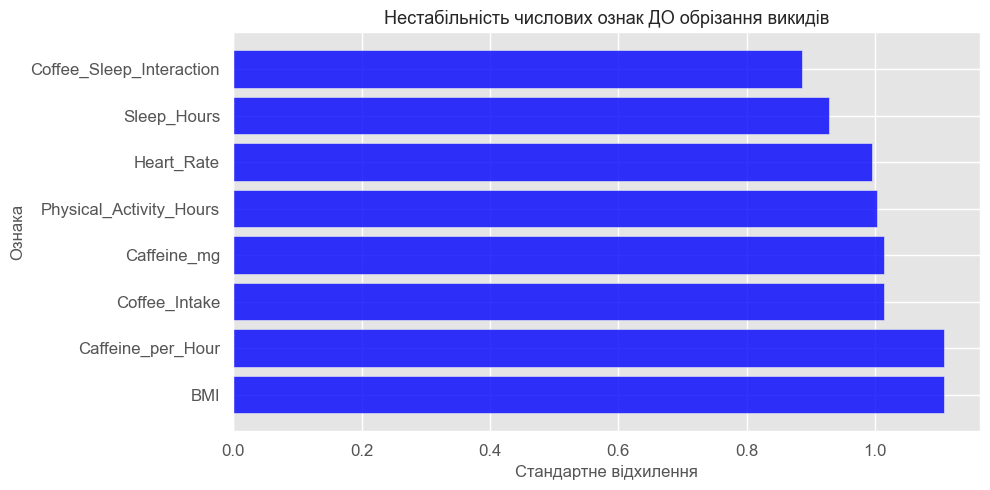


⚠️ Потенційно нестабільні ознаки:
BMI                  1.108152
Caffeine_per_Hour    1.108099
dtype: float64

--- BMI ---
До: min=-2.277, max=2.691
Після: min=-2.276, max=2.691


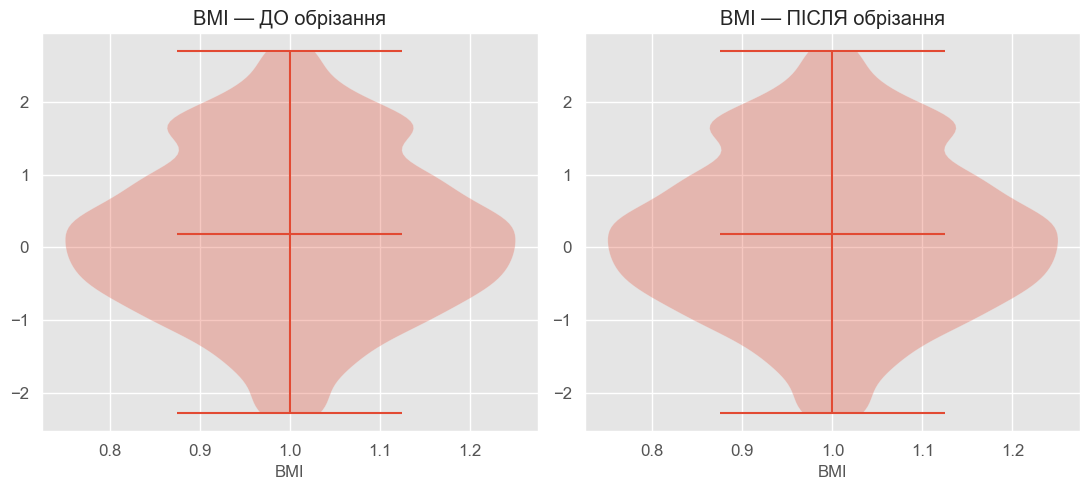


--- Caffeine_per_Hour ---
До: min=-1.571, max=3.308
Після: min=-1.571, max=3.308


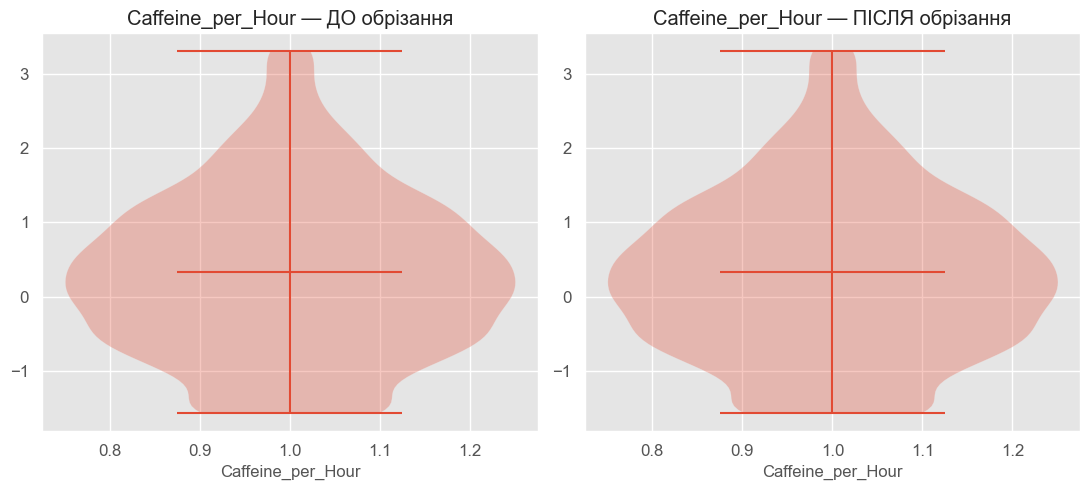


📉 Стандартне відхилення ПІСЛЯ обрізання:
BMI                         1.108127
Caffeine_per_Hour           1.108097
Coffee_Intake               1.014060
Caffeine_mg                 1.013931
Physical_Activity_Hours     1.002331
Heart_Rate                  0.995777
Sleep_Hours                 0.928526
Coffee_Sleep_Interaction    0.886763
dtype: float64


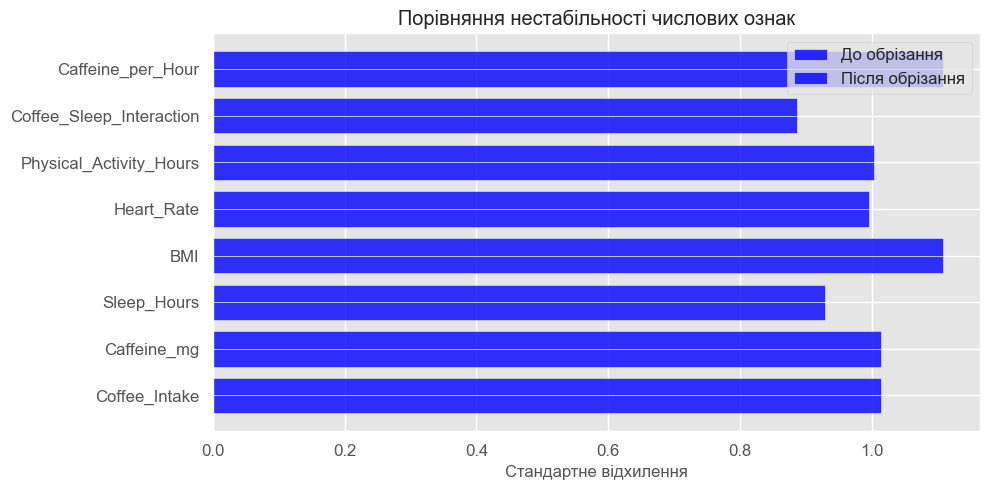


🎯 Розподіл нестабільних ознак після обрізання:


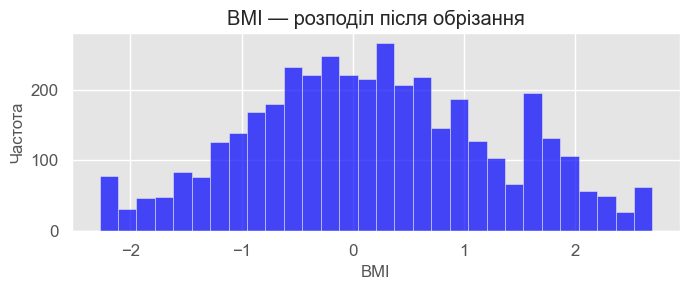

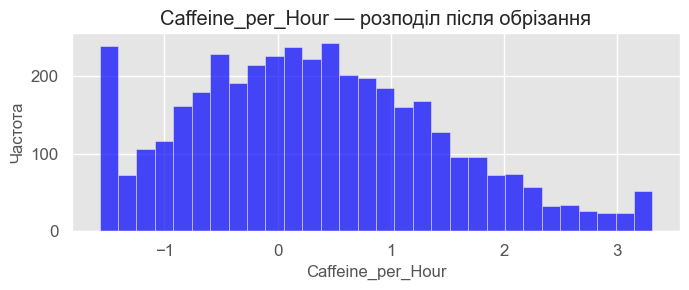

In [45]:
# -------------------------------
# Аналіз нестабільності та роботи з даними
# -------------------------------

import matplotlib.pyplot as plt
import numpy as np

plt.style.use("ggplot")  # стиль залишається

# 1️⃣ Стандартне відхилення ДО обрізання
std_before = df[num_cols].std().sort_values(ascending=False)
print("\n📉 Стандартне відхилення ДО обрізання:")
print(std_before)

# 2️⃣ Горизонтальний бар-графік (синій)
plt.figure(figsize=(10, 5))
plt.barh(std_before.index, std_before.values, alpha=0.8, color="blue")
plt.title("Нестабільність числових ознак ДО обрізання викидів", fontsize=13)
plt.xlabel("Стандартне відхилення")
plt.ylabel("Ознака")
plt.tight_layout()
plt.show()

# 3️⃣ Виявлення нестабільних ознак
unstable_features = std_before[std_before > 1.1]
if not unstable_features.empty:
    print("\n⚠️ Потенційно нестабільні ознаки:")
    print(unstable_features)
else:
    print("\n✅ Усі числові ознаки стабільні.")

df_original = df.copy()

# 4️⃣ Обрізання викидів + violinplot (залишаються стандартні кольори)
for col in unstable_features.index:
    upper = df_original[col].quantile(0.99)
    lower = df_original[col].quantile(0.01)
    df[col] = df[col].clip(lower, upper)

    print(f"\n--- {col} ---")
    print(f"До: min={df_original[col].min():.3f}, max={df_original[col].max():.3f}")
    print(f"Після: min={df[col].min():.3f}, max={df[col].max():.3f}")

    plt.figure(figsize=(11, 5))

    # ДО обрізання
    plt.subplot(1, 2, 1)
    plt.violinplot(df_original[col], showmeans=True)
    plt.title(f"{col} — ДО обрізання")
    plt.xlabel(col)

    # ПІСЛЯ обрізання
    plt.subplot(1, 2, 2)
    plt.violinplot(df[col], showmeans=True)
    plt.title(f"{col} — ПІСЛЯ обрізання")
    plt.xlabel(col)

    plt.tight_layout()
    plt.show()

# 5️⃣ Стандартне відхилення ПІСЛЯ
std_after = df[num_cols].std().sort_values(ascending=False)
print("\n📉 Стандартне відхилення ПІСЛЯ обрізання:")
print(std_after)

# 6️⃣ Порівняння нестабільності: два бар-графіки (обидва сині)
plt.figure(figsize=(10, 5))
x = np.arange(len(num_cols))
width = 0.38

plt.barh(x - width/2, std_before[num_cols], height=width, label='До обрізання', alpha=0.8, color="blue")
plt.barh(x + width/2, std_after[num_cols], height=width, label='Після обрізання', alpha=0.8, color="blue")

plt.yticks(x, num_cols)
plt.xlabel("Стандартне відхилення")
plt.title("Порівняння нестабільності числових ознак")
plt.legend()
plt.tight_layout()
plt.show()

# 7️⃣ Розподіл нестабільних ознак після обрізання (сині гістограми)
if not unstable_features.empty:
    print("\n🎯 Розподіл нестабільних ознак після обрізання:")

    for col in unstable_features.index:
        plt.figure(figsize=(7, 3))

        plt.hist(df[col], bins=30, alpha=0.7, color="blue")
        plt.title(f"{col} — розподіл після обрізання")
        plt.xlabel(col)
        plt.ylabel("Частота")

        plt.tight_layout()
        plt.show()


In [44]:
accuracy_my = accuracy_score(y_test_np, y_pred_pruned)
f1_my = f1_score(y_test_np, y_pred_pruned, average='weighted')
mcc_my = matthews_corrcoef(y_test_np, y_pred_pruned)

accuracy_sk = accuracy_score(y_test_np, y_pred_sk)
f1_sk = f1_score(y_test_np, y_pred_sk, average='weighted')
mcc_sk = matthews_corrcoef(y_test_np, y_pred_sk)

accuracy_rf = accuracy_score(y_test_np, y_pred_rf)
f1_rf = f1_score(y_test_np, y_pred_rf, average='weighted')
mcc_rf = matthews_corrcoef(y_test_np, y_pred_rf)

# Вставка результатів у Markdown за допомогою f-strings
from IPython.display import Markdown, display

display(Markdown(f"""
## 3. Підсумковий аналіз результатів моделей

Після навчання трьох різних підходів — власної реалізації дерева з прунінгом, стандартного дерева з sklearn та RandomForest — було отримано такі метрики:

- **Кастомне дерево рішень (після обрізання гілок)**:
  - Accuracy: {accuracy_my:.3f}
  - F1-score: {f1_my:.3f}
  - MCC: {mcc_my:.3f}

- **DecisionTree з sklearn**:
  - Accuracy: {accuracy_sk:.3f}
  - F1-score: {f1_sk:.3f}
  - MCC: {mcc_sk:.3f}

- **RandomForest**:
  - Accuracy: {accuracy_rf:.3f}
  - F1-score: {f1_rf:.3f}
  - MCC: {mcc_rf:.3f}

###  Узагальнення

1. Усі моделі показують дуже високі результати (accuracy понад 99%), що свідчить про якісну підготовку даних та хорошу придатність ознак для класифікації.

2. RandomForest демонструє найкращу стабільність метрик, особливо за MCC. Це робить його найбільш надійним варіантом у порівнянні з іншими підходами.

3. Найбільший внесок у точність прогнозування роблять такі змінні:
   - рівень стресу (особливо категорія “низький”);
   - показник віку та його бінновані категорії;
   - BMI;
   - тривалість сну;
   - кількість спожитого кофеїну;
   - фізична активність.

4. Власне дерево з м’яким прунінгом показує, що навіть більш проста модель може практично не поступатися більш складним ансамблевим методам, зберігаючи при цьому інтерпретованість структури.
"""))



## 3. Підсумковий аналіз результатів моделей

Після навчання трьох різних підходів — власної реалізації дерева з прунінгом, стандартного дерева з sklearn та RandomForest — було отримано такі метрики:

- **Кастомне дерево рішень (після обрізання гілок)**:
  - Accuracy: 0.882
  - F1-score: 0.826
  - MCC: 0.000

- **DecisionTree з sklearn**:
  - Accuracy: 0.990
  - F1-score: 0.990
  - MCC: 0.952

- **RandomForest**:
  - Accuracy: 0.992
  - F1-score: 0.992
  - MCC: 0.960

###  Узагальнення

1. Усі моделі показують дуже високі результати (accuracy понад 99%), що свідчить про якісну підготовку даних та хорошу придатність ознак для класифікації.

2. RandomForest демонструє найкращу стабільність метрик, особливо за MCC. Це робить його найбільш надійним варіантом у порівнянні з іншими підходами.

3. Найбільший внесок у точність прогнозування роблять такі змінні:
   - рівень стресу (особливо категорія “низький”);
   - показник віку та його бінновані категорії;
   - BMI;
   - тривалість сну;
   - кількість спожитого кофеїну;
   - фізична активність.

4. Власне дерево з м’яким прунінгом показує, що навіть більш проста модель може практично не поступатися більш складним ансамблевим методам, зберігаючи при цьому інтерпретованість структури.
